## Imports

In [16]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob

import cv2

# create a venv >> python -m venv .venv
# activate the venv >> .venv\Scripts\activate
# install opencv >> pip install opencv-python
# >> pip install ipykernel numpy matplotlib
# >> python -m ipykernel install --user --name=stereo_vision --display-name="StereoVision (venv)"

In [17]:
# ----- Helpers --------
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return np.uint8(gray)

## Calibration

### Docs

In [18]:
### Documentation :


# cv2.findChessboardCorners(): This function is used to find the chessboard corners in an image.
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a

# cv2.cornerSubPix(): This function will improve precision of corner's positions.    
    # https://docs.opencv.org/4.0.0/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e

# cv2.drawChessboardCorners(): This function will draw found corners for visual validation purpose. 
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022

# cv2.calibrateCamera(): This function will compute rotation vectors, and , based on corners found on multiple chessboards.
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d

### Implementation

In [19]:
def detect_chessboard_corners(image_path, pattern_size=(7, 7)):
    """
    Detect corners in an image and return results for display.
    """
    # Read
    img = cv2.imread(image_path)
        
    # Convert to grayscale
    grey = rgb2gray(img)
    
    # Find chessboard corners
    retval, corners = cv2.findChessboardCorners(img, pattern_size, None)
    
    # Prepare result dictionary
    result = {
        'success': retval,
        'image_rgb': cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
        'corners': None,
        'image_with_corners': cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    }
    
    if retval:
        # Improve corner precision
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        refined_corners = cv2.cornerSubPix(grey, corners, (11, 11), (-1, -1), criteria)
        
        # Draw corners on a copy of the image
        img_with_corners = img.copy()
        cv2.drawChessboardCorners(img_with_corners, pattern_size, refined_corners, retval)
        
        # Update result
        result['corners'] = refined_corners
        result['image_with_corners'] = cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB)
    
    return result

### Example

Corners detected successfully in both images!
Left image corners shape: (49, 1, 2)
Right image corners shape: (49, 1, 2)


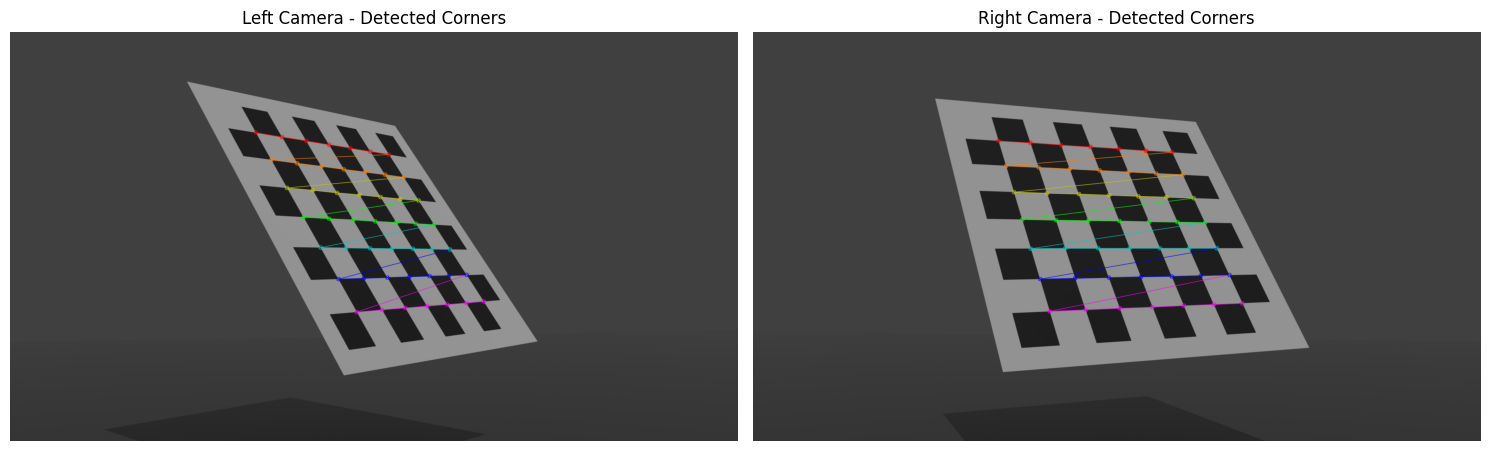

In [20]:
# EXAMPLE: set of one L/R images
result_left = detect_chessboard_corners("./chessboards/c1Left.png")
result_right = detect_chessboard_corners("./chessboards/c1Right.png")

# Display results
if result_left['success'] and result_right['success']:
    print("Corners detected successfully in both images!")
    print(f"Left image corners shape: {result_left['corners'].shape}")
    print(f"Right image corners shape: {result_right['corners'].shape}")
else:
    print(f"Corner detection - Left: {result_left['success']}, Right: {result_right['success']}")


# ====================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Display left image with corners
ax1.imshow(result_left['image_with_corners'])
ax1.set_title('Left Camera - Detected Corners')
ax1.axis('off')

# Display right image with corners
ax2.imshow(result_right['image_with_corners'])
ax2.set_title('Right Camera - Detected Corners')
ax2.axis('off')

plt.tight_layout()
plt.show()

### Camera Calibration

In [ ]:
# INPUT:
    # objectPoints: Vector of vectors of calibration pattern points in the calibration pattern coordinate space.
    # imagePoints: 	Vector of vectors of the projections of calibration pattern points.
    # imageSize: Size of the image used only to initialize the intrinsic camera matrix.

# OUTPUT:
    # retval: RMS reprojection error
    # cameraMatrix:  Refined camera intrinsic matrix
    # distCoeffs: Output vector of distortion coefficients.
    # rvecs: Output vector of rotation vectors
    # tvecs 

# More images passed -> better results
# Pass a list of images, receive a list of Projection Matrixes P.
# Choose the final P and P' based on the image with the orientation the most similar to final 3D image (here c4.png)


def calibrate_camera(img_list, pattern_size):
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)            # Shape: (49, 3) for 7×7 corners
    objp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)  # copy objp for each image
    object_points = []  # 3D points in real world space
    image_points = []   # 2D points in image plane
    successful_images = [] 

    for i in img_list:
        result = detect_chessboard_corners(i, pattern_size)
        if result["success"]:
            object_points.append(objp)
            image_points.append(result["corners"])
            successful_images.append(i)

    # Get image size from the first image
    first_img = cv2.imread(img_list[0])
    image_size = (first_img.shape[1], first_img.shape[0])  # (width, height)
        #print(f"Image size: {image_size}")

    # Calibrate camera
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        object_points, 
        image_points, 
        image_size, 
        None,  # Let OpenCV estimate initial camera matrix
        None   # Let OpenCV estimate initial distortion coefficients
    )

    return ret, camera_matrix, dist_coeffs, rvecs, tvecs, successful_images


In [ ]:
# Load images
img_list = glob.glob("./chessboards/*.png")
print("Found images:", len(img_list))

# Get Results
result = calibrate_camera(img_list, (7,7))
ret, camera_matrix, dist_coeffs, rvecs, tvecs, successful_images = result

# Choose images c4, as they have the most frontal view of the chessboard (index 6 and 7 in img_list)
chosen_img_left = "c4Left.png"
chosen_img_right = "c4Right.png"

# Find indices
left_idx = next(i for i, path in enumerate(successful_images) if chosen_img_left in path)
right_idx = next(i for i, path in enumerate(successful_images) if chosen_img_right in path)

# Extract parameters for both
ret_left, mtx_left, dist_left = ret, camera_matrix, dist_coeffs
rvec_left, tvec_left = rvecs[left_idx], tvecs[left_idx]

ret_right, mtx_right, dist_right = ret, camera_matrix, dist_coeffs  
rvec_right, tvec_right = rvecs[right_idx], tvecs[right_idx]

# Display results
print(f"Left: rvec={rvec_left.flatten()}, tvec={tvec_left.flatten()}")
print(f"Right: rvec={rvec_right.flatten()}, tvec={tvec_right.flatten()}")


Found images: 8
Left: rvec=[-0.06132213 -0.18139791  0.07797372], tvec=[-2.29981703 -3.66547701 19.81589076]
Right: rvec=[-0.04652954  0.21514511  0.06877919], tvec=[-2.25734706 -3.61952184 20.69358646]


### Projection Matrixes

In [ ]:
# Convert rotation vectors to rotation matrices
R_left, _ = cv2.Rodrigues(rvec_left)   # 3x3 rotation matrix
R_right, _ = cv2.Rodrigues(rvec_right) # 3x3 rotation matrix

# Build extrinsic matrices [R|t] (3x4)
RT_left = np.hstack([R_left, tvec_left.reshape(-1, 1)])
RT_right = np.hstack([R_right, tvec_right.reshape(-1, 1)]) 

# Build projection matrices P = K * [R|t] (3x4)
P_left = camera_matrix @ RT_left
P_right = camera_matrix @ RT_right

print("Left Projection Matrix P:")
print(P_left)
print("\nRight Projection Matrix P':")
print(P_right)
print(f"\nCheck dimensions ok (3x4): P_left={P_left.shape}, P_right={P_right.shape}")

Left Projection Matrix P:
[[ 2.22944859e+03 -2.16122221e+02  5.59152156e+02  1.41915121e+04]
 [ 2.70022582e+02  2.05272342e+03  6.42408937e+02  2.98882870e+03]
 [ 1.77726091e-01 -6.79331712e-02  9.81732408e-01  1.98158908e+01]]

Right Projection Matrix P':
[[ 1.84010634e+03 -1.90794040e+02  1.38108917e+03  1.51231407e+04]
 [ 1.68294914e+01  2.07154499e+03  6.38508411e+02  3.55858569e+03]
 [-2.14836214e-01 -3.87521897e-02  9.75880971e-01  2.06935865e+01]]

Shapes: P_left=(3, 4), P_right=(3, 4)
